In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow. keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import keras,os
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
batch_size = 32
img_height =180
img_width = 180
epochs=120

In [28]:
# RUN_ENV='MIKE'
RUN_ENV='GERRY'

In [4]:
import socket
import uuid
import sqlalchemy
def save_model_history_to_cloud(history,model_name):
    driver='mysql+mysqlconnector'
    username='admin'
    password='LuIboUmvFq1yobCGI9AQ'
    dbhost='datadb.ca0fpkbqdjfv.ca-central-1.rds.amazonaws.com'
    dbport='3306'
    dbname='dsdb'
    conn_string=driver+'://'+username+':'+password+'@'+dbhost+':'+dbport+'/'+dbname
    engine = sqlalchemy.create_engine(conn_string)
    model_data = pd.DataFrame.from_dict(history.history)
    model_data['machine']=socket.gethostname()
    model_data['total_epochs']=len(history.history['accuracy'])
    model_data['epochs']=model_data.index+1
    runid=str(uuid.uuid4())
    model_data['runid']=runid
    model_data['model_name']=model_name
    model_data.to_sql('model_data',engine, if_exists='append', chunksize=1000)
    return runid


In [5]:
### get physical GPU
if RUN_ENV=='GERRY':
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
data_dir='C:/Users/zheny/Downloads/608/Final project/NewData'

if RUN_ENV=='GERRY':
    data_dir='C:/Project 607_608/NewData'


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9821 files belonging to 2 classes.
Using 7857 files for training.
Found 9821 files belonging to 2 classes.
Using 1964 files for validation.


In [7]:
class_names = train_ds.class_names

print(class_names)

['face_no_mask', 'face_with_mask']


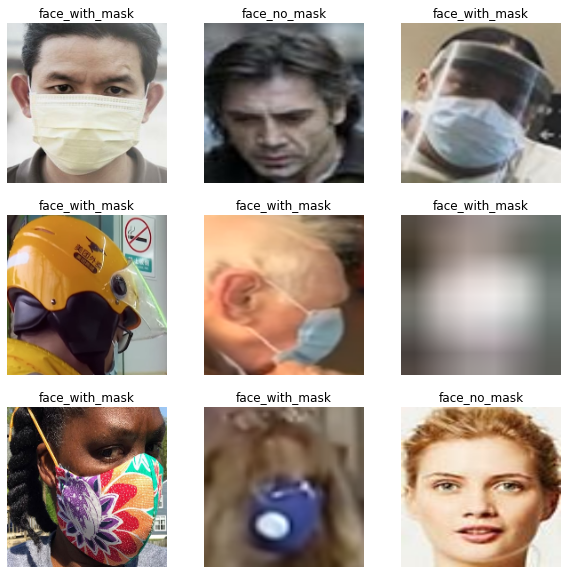

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
base_model19 = tf.keras.applications.VGG19(include_top = False, input_shape = (180,180,3),weights='imagenet')
base_model19.trainable = False



In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model19(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [12]:
base_model19.trainable = False

In [13]:
base_model19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model19(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
# x = Flatten()(base_model19.output)
# # x = Dense(256, activation='relu')(x)
# prediction19 = Dense(1)(x)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')

In [21]:
hist= model.fit(train_ds, batch_size = batch_size, epochs = epochs, validation_data = val_ds,steps_per_epoch=len(train_ds),
  validation_steps=len(val_ds),callbacks=[early_stop])
model.save('VGG19-Face Mask Detection1.h5')
model.evaluate(val_ds)

Epoch 1/120
246/246 [==============================] - 25s 92ms/step - loss: 1.8091 - accuracy: 0.5359 - val_loss: 0.9949 - val_accuracy: 0.7006
Epoch 2/120
246/246 [==============================] - 20s 79ms/step - loss: 0.8787 - accuracy: 0.7222 - val_loss: 0.5856 - val_accuracy: 0.8030
Epoch 3/120
246/246 [==============================] - 20s 79ms/step - loss: 0.6597 - accuracy: 0.7716 - val_loss: 0.3918 - val_accuracy: 0.8625
Epoch 4/120
246/246 [==============================] - 20s 80ms/step - loss: 0.4951 - accuracy: 0.8098 - val_loss: 0.2947 - val_accuracy: 0.8900
Epoch 5/120
246/246 [==============================] - 20s 80ms/step - loss: 0.4061 - accuracy: 0.8398 - val_loss: 0.2466 - val_accuracy: 0.9038
Epoch 6/120
246/246 [==============================] - 20s 81ms/step - loss: 0.3752 - accuracy: 0.8533 - val_loss: 0.2166 - val_accuracy: 0.9140
Epoch 7/120
246/246 [==============================] - 20s 81ms/step - loss: 0.3248 - accuracy: 0.8712 - val_loss: 0.1949 - val_ac

[0.10403140634298325, 0.954684317111969]

In [22]:
rid=save_model_history_to_cloud(hist,'VGG19')

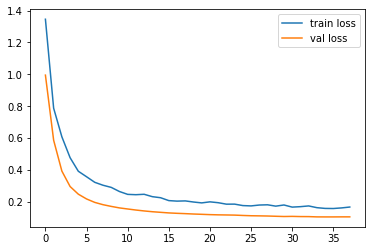

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

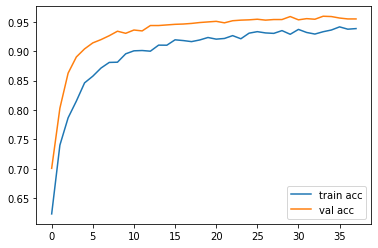

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

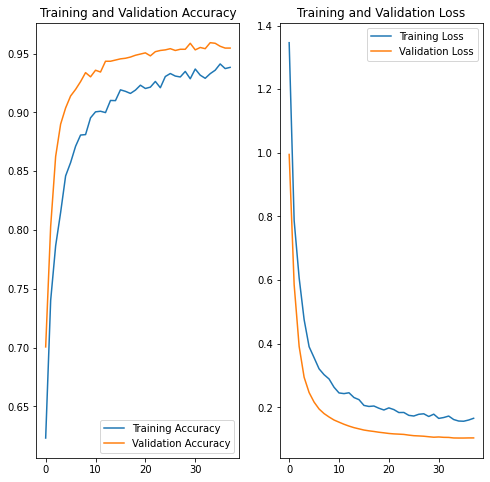

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(len(hist.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

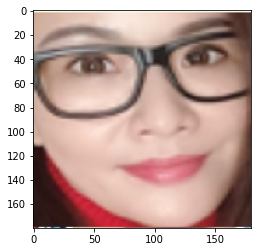

In [31]:
from keras.preprocessing import image
img=''
if RUN_ENV=='MIKE':
    img=image.load_img('C:/Users/zheny/Downloads/608/Final project/NewData/5255_0_face_no_mask.jpg', target_size=(180,180))
if RUN_ENV=='GERRY':
    img=image.load_img('C:/Final/Sample/no_mask_5.png', target_size=(180,180))
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)

In [32]:
from keras.models import load_model
saved_model=load_model('VGG16-Face Mask Detection1.h5')
output=saved_model.predict(img)
if output[0]>0:
    print("face with mask")
else:
    print("face without mask")


face without mask


Predictions:
 [0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1]
Labels:
 [0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1]


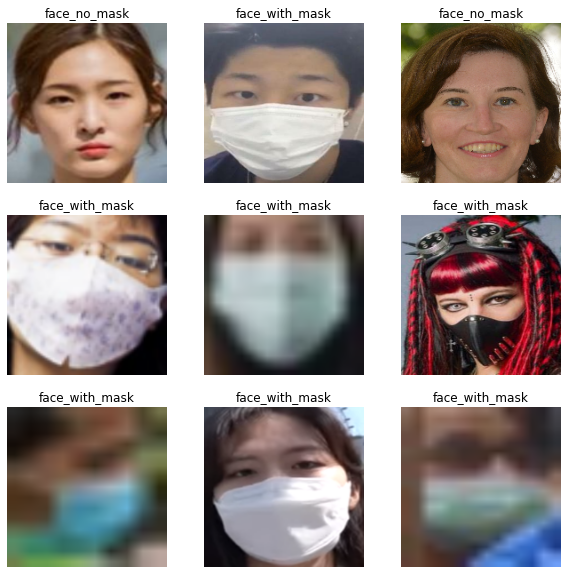

In [33]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")